In [1]:
from utilities import image_preprocess
from image_gen import generate_test_image
from solvers import of_vc
from plotters import init_image_results, run_all_image, init_lambda_results, run_all_lambda, plot_flow_field, plot_performance, plot_performance_lambda, plot_quiver, plot_quiver_lambda , summarize_results, run_vc_param_grid,plot_vc_param_comparison, plot_gaussian_gradients


## TMA4205 - Estimation of Optical Flow
##### Julie Rose Godal og Tor Løvold Haugen
----

### Introduction
Optical flow describes the apparent motion of image intensity over time and is used to estimate how points in an image move between two consecutive frames. In this project, the problem is modeled using the Horn–Schunck method, which assumes that the intensity of a point remains constant as it moves. This leads to a linear system of partial differential equations that can be solved numerically after discretization. The work focuses on formulating this system, analyzing its properties, and implementing different numerical approaches to compute the solution, including the Conjugate Gradient (CG) method, Gauss–Seidel smoothing, and a multigrid V–cycle. Finally we will discuss the performance of these methods with different parameters and settings, with the goal of understanding their behavior and effectiveness in various scenarios.


### Theory
The optical flow field $(u,v)$ between two consecutive grayscale frames $I_0$ and $I_1$ is modeled using the Horn–Schunck method. Assuming brightness constancy together with quadratic smoothness, leads to the energy functional
$$
E(u,v) = \int \big( (I_x u + I_y v + I_t)^2 + \lambda (\|\nabla u\|^2 + \|\nabla v\|^2) \big)\, dx\, dy,
$$
where $\lambda > 0$ controls the balance between data quality and smoothness. Minimizing this energy yields the coupled Euler–Lagrange equations
$$
(I_x)^2u + (I_x I_y)v - \lambda \Delta u = -I_x I_t, \qquad
(I_x I_y)u + (I_y)^2v - \lambda \Delta v = -I_y I_t,
$$
subject to Dirichlet boundary conditions $u = v = 0$ on the image boundary.

In the discrete setting, the image domain is represented on an $m \times n$ grid with unit spacing. The temporal derivative is given by $I_t = I_1 - I_0$, while the spatial derivatives $I_x$ and $I_y$ are computed using forward finite differences and averaged across the two frames.


We examine the linear system obtained after discretizing the Horn–Schunck optical flow equations. Understanding its general structure, coupling, and boundary behavior is essential before choosing suitable numerical methods. We will then discuss how these characteristics influence the stability and solvability of the numerical problem.

The discrete system of equations for each pixel $(i,j)$ can be written as

$$
(\partial_x I_{ij})^2\, u_{ij} 
+ \partial_x I_{ij}\, \partial_y I_{ij}\, v_{ij}
- \lambda (A_h^0 u)_{ij}
= - (\partial_t I)_{ij} (\partial_x I)_{ij},
$$

$$
(\partial_y I_{ij})^2\, v_{ij}
+ \partial_y I_{ij}\, \partial_x I_{ij}\, u_{ij}
- \lambda (A_h^0 v)_{ij}
= - (\partial_t I)_{ij} (\partial_y I)_{ij}.
$$

These equations represent two coupled linear relations between the horizontal and vertical flow components, where the terms involving spatial derivatives of the image couple $u$ and $v$, and the Laplacian term enforces smoothness through the regularization parameter $\lambda$.

We define the spatial and temporal derivatives for simplicity as

$$
I_x := \partial_x I, \qquad
I_y := \partial_y I, \qquad
I_t := \partial_t I.
$$

Substituting these into the equations gives the form

$$
I_x^2 u + I_x I_y v - \lambda A_h^0 u = - I_t I_x,
$$

$$
I_y^2 v + I_x I_y u - \lambda A_h^0 v = - I_t I_y.
$$

Here, $A_h^0$ denotes the discrete Laplacian operator acting on the interior of the image domain.

To express this system in matrix form, we introduce diagonal matrices containing the image-dependent coefficients:

$$
D_{xx} = \mathrm{diag}(I_x^2), \qquad
D_{yy} = \mathrm{diag}(I_y^2), \qquad
D_{xy} = \mathrm{diag}(I_x I_y).
$$

This yields the full coupled system

$$
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}
\begin{bmatrix}
U \\[2pt] V
\end{bmatrix}
=
\begin{bmatrix}
D_{xt} \\[2pt] D_{yt}
\end{bmatrix}.
$$

The structure of this matrix shows that the system couples $u$ and $v$ symmetrically through the off-diagonal blocks $D_{xy}$, while the diagonal blocks contain both the image gradient terms and the regularization operator. Thus, the coefficient matrix $A$ is symmetric and, for $\lambda > 0$, positive definite on the interior domain.

To analyze the definiteness of the system matrix, we split it into two parts. A diagonal part that depends on the image derivatives, and a Laplacian part that represents the regularization. This shows how each term contributes to the overall stability of the system.

We write the matrix as

$$
A =
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
-
\begin{bmatrix}
\lambda A_h^0 & 0 \\
0 & \lambda A_h^0
\end{bmatrix}.
$$

The second term contains the discrete Laplacian $A_h^0$ with Dirichlet boundary conditions. It is known that the negative Laplacian under these conditions is symmetric positive definite (SPD), meaning that it contributes positively to the energy and stabilizes the system through smoothing.

Next, we analyze the diagonal part $D$, which depends on the image gradients. Let $x_1, x_2 \in \mathbb{R}$ represent arbitrary scalar coefficients, then

$$
x^T D x
=
\begin{bmatrix} x_1 & x_2 \end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
=
x_1^2 D_{xx} + 2x_1 x_2 D_{xy} + x_2^2 D_{yy}.
$$

This expression represents the local quadratic form associated with the data term at each pixel. Since the matrices $D_{xx}$, $D_{yy}$, and $D_{xy}$ are diagonal, the computation can be written element-wise as

$$
x^T D x = \sum_i (x_1 I_{x,i} + x_2 I_{y,i})^2 > 0.
$$

Each term in the sum is nonnegative and only vanishes if both $I_{x,i}$ and $I_{y,i}$ are zero simultaneously. Therefore, $D$ must be at least symmetric semi-positive definite.

Since the Laplacian part is SPD and the diagonal part is semi-positive definite, their sum must be SPD for $\lambda > 0$. This means that the full system matrix $A$ is symmetric positive definite, ensuring that the optical flow equations admit a unique and stable solution.

To investigate the diagonal dominance of the system matrix, we analyze the relative size of the diagonal and off-diagonal elements in each block. 

We start by writing the matrix as

$$
A =
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}.
$$

Here, $D_{xx}$ and $D_{yy}$ are diagonal matrices containing image-gradient terms, while $A_h^0$ is the discrete Laplacian. The Laplacian contributes positive diagonal entries $d_i > 0$ and negative off-diagonal entries $-1$ corresponding to neighboring pixels.

For the $u$-component, the diagonal entry at pixel $i$ is

$$
a_{ii} = I_x[i]^2 + \lambda d_i,
$$

while the off-diagonal entries come from the Laplacian and the coupling to $v$. Neighboring pixels: $a_{ij} = -\lambda$ for $j \in \mathcal{N}(i)$. Cross-block coupling: $a_{i, N+i} = I_x[i] I_y[i]$

Diagonal dominance requires that the magnitude of the diagonal entry is greater than or equal to the sum of the magnitudes of the off-diagonal entries:

$$
|a_{ii}| \ge \sum_{j\neq i} |a_{ij}|.
$$

Substituting the expressions gives

$$
I_x[i]^2 + \lambda d_i \ge \lambda d_i + |I_x[i] I_y[i]|.
$$

After canceling the regularization terms, this simplifies to

$$
I_x[i]^2 \ge |I_x[i] I_y[i]|.
$$

Applying the same reasoning to the $v$-component gives

$$
I_y[i]^2 \ge |I_x[i] I_y[i]|.
$$

The conditions for diagonal dominance in both blocks are therefore

$$
|I_x[i]| \ge |I_y[i]|, \qquad |I_y[i]| \ge |I_x[i]|.
$$

These two inequalities can only hold simultaneously if

$$
|I_x[i]| = |I_y[i]|.
$$

This means that strict diagonal dominance occurs only in special cases where the horizontal and vertical image gradients have equal magnitude at every pixel. Hence global diagonal dominance of \(A\) cannot be guaranteed.

In summary, the discretized optical flow system forms a large, sparse, symmetric linear system whose properties are determined by the local image derivatives and the chosen regularization.By separating the operator into a data-dependent diagonal part and a regularization-based Laplacian part, we see that both components combined are SPD. Consequently, the full system matrix $A$ is symmetric positive definite. While the diagonal and Laplacian contributions stabilize the system, the presence of cross-coupling terms $I_x I_y$ prevents strict diagonal dominance in most cases. 

The lack of global diagonal dominance implies that the Jacobi method is not guaranteed to converge for this system, since its convergence typically relies on the diagonal elements dominating the off-diagonal ones. This is because the convergence of this method rely on the spectral radius of their itereation matrix. And they only converge if the spectral radius, $\rho$, is less than one, which can only be guaranteed by strict diagonal dominence. In practice, these methods may still work for some images but can converge slowly or even diverge depending on the local image gradients and coupling strength.

In contrast, the Conjugate Gradient (CG) method only requires the coefficient matrix to be symmetric positive definite, which we have shown to hold for this system. For the Gauss-Seidel metod an SPD system also converges. Therefore, Gaus-Seidel and CG is both theoretically guaranteed to converge, and CG is generally much more efficient for solving the discretized Horn–Schunck equations.

### Implementation of Numerical Methods
#### Conjugate-Gradient
From the previous section, it is known that this system operator is symmetric and positive definite, but not globally diagonally dominant. Therefore, the linear system $A(u,v)=b$ is most efficiently solved with the Conjugate Gradient (CG) method. 

The CG method iteratively minimizes the quadratic energy associated with the system matrix by updating the solution along mutually conjugate search directions. In each iteration, a step length is computed to minimize the residual in the current direction, and a new search direction is formed as a combination of the current residual and the previous direction. This ensures that convergence occurs in at most as many steps as the number of unknowns.

When implementing this method, a five-point Laplacian is applied only on the strict interior. All inner products and updates are restricted to interior indices, while the border remains clamped to zero. Thus, boundary pixels are excluded from all linear algebra and kept at zero, which enforces the dirichlet condition.


#### Multigrid V–Cycle
To improve the efficiency of solving the Horn–Schunck optical flow equations, a multigrid V–cycle is used. The discrete system solved on the interior can be written as
$$
A(u, v) = [ [Ix², IxIy], [IxIy, Iy²] ] [u, v]^T - λ[Δu, Δv]^T = [-IxIt, -IyIt]^T,
$$
where λ is the regularization parameter and u = v = 0 on the boundary. The multigrid approach combines local smoothing and coarse-grid correction to remove errors at all spatial frequencies more efficiently than a single grid method.

The smoother applies a red–black Gauss–Seidel iteration that updates interior pixels alternately by solving a small coupled 2×2 system for each pixel. This reduces high-frequency errors in both u and v while keeping the boundary fixed at zero. After a few pre-smoothing sweeps, the residual r = b − A(u, v) is computed and transferred to a coarser grid using restriction. Restriction is done with full-weighting, averaging neighboring values with weights [1/4, 1/2, 1/4] in both directions. The image derivatives Ix and Iy are restricted in the same way to preserve the structure of the operator.

On the coarse grid, the error equation is solved approximately, either by recursion to the next coarser level or, at the coarsest grid, by a small number of Conjugate Gradient iterations. The resulting coarse-grid error is interpolated back to the fine grid through prolongation using bilinear interpolation, and the fine-grid solution is corrected by adding this interpolated error. A few post-smoothing sweeps are then applied to remove the remaining high-frequency errors.

Each V–cycle therefore performs pre-smoothing, residual computation, restriction, coarse solve, prolongation, and post-smoothing. This hierarchy of grids efficiently removes both low- and high-frequency components of the error, producing grid-independent convergence for the coupled optical flow equations while maintaining Dirichlet boundaries and the coupling between u and v through the image derivatives.

#### V-cycle as a preconditioner for Conjugate gradient: 
We have established that CG requiers the system to be linear and SPD. The V-cycle can be considered linear, as the smoothing is linear (using Gaus-Seidel on a SPD linear system). The smoothing will be further discussed for SPD.
The restriction and prolongation has to be linear. 
The coarse solver (in our case CG) has to be linear. This is assumed as we use CG in the small linear SPD system in the coarse step.


As the conjugate gradient method requieres a SPD matrix A to be guaranteed convergence, the preconditioner needs to keep these properties for A. In in out code this is implemented as the presmoother beeing RB ordered and the postsmoother beeing BS ordered. 
In the following we prove that applying RB-BR preserves SPD-properties. For this to be correct, the number of sweeps also have to be the same for the presmoothing and postsmoothing(s1=s2).

For the intergrid transfer operators we use standard bilinear
interpolation for prolongation and full-weighting for restriction.
On the fine grid, the prolongation operator P is defined by
injecting coarse values at every second grid point and using linear
interpolation along edges and bilinear interpolation in the cell
centres. The restriction operator R uses the classical 3×3
full-weighting stencil

$$
\frac{1}{16}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$

around each coarse-grid point. In 1D, it is well known that
full-weighting restriction and linear interpolation satisfy
$R = \tfrac{1}{2} P^\top$; in 2D, the operators are tensor products
of the 1D ones, so we obtain $R = \tfrac{1}{4} P^\top$.
Thus, up to a constant factor, the restriction is the adjoint of the
prolongation. With the Galerkin definition of the coarse-grid operator,
$
A_{2h} = R A_h P,
$
this choice guarantees that $A_{2h}$ remains symmetric whenever $A_h$
is symmetric. Together with the symmetric RB–BR Gauss–Seidel smoother,
this ensures that the resulting V-cycle defines a symmetric,
positive definite preconditioner suitable for use with CG.
Thus the Restriction and prolongation is linear and preserves the symmetry of the problem. 

##### Lemma (RB→BR keeps SPD)
Let $A \in \mathbb{R}^{n \times n}$ be **symmetric positive definite (SPD)** and let a red–black
coloring of the grid induce a permutation of the unknowns that puts all red nodes
first and all black nodes second. Denote this permutation by an orthogonal
(permutation) matrix $\Pi$ and the permuted matrix by
$$
\tilde A = \Pi^\top A \Pi.
$$
Then $\tilde A$ is SPD. We split
$$
\tilde A = D + L + L^\top,
$$
where $D$ is block diagonal in this ordering and $L$ is strictly
lower triangular.

Consider one red–black forward Gauss–Seidel sweep followed by one
black–red backward Gauss–Seidel sweep on $\tilde A$. The combined update
has the form
$$
x^{(2)} = x^{(0)} + \tilde B_{\mathrm{SGS}}\,(b-\tilde A x^{(0)}),
\qquad
\tilde B_{\mathrm{SGS}} = (D+L^\top)^{-1} D (D+L)^{-1}.
$$
Then $\tilde B_{\mathrm{SGS}}$ is **SPD**. Therefore, the corresponding operator in the
original ordering,
$$
B_{\mathrm{SGS}} = \Pi\,\tilde B_{\mathrm{SGS}}\,\Pi^\top,
$$
is also SPD. Therefore, RB presmoothing followed by BR postsmoothing preserves SPD.

##### Proof

Red-Black and Black-Red ordering: We want to show that applying first Red-Black and then Black-Red yealds the Symmetric Gaus-Seidel method
Let $r^{(0)} := b - \tilde A x^{(0)}$.

A forward Gauss–Seidel sweep (RB in this ordering) is
$$
x^{(1)} = x^{(0)} + (D+L)^{-1} r^{(0)}.
$$

And 
$$
r^{(1)} = -\,L^\top (D+L)^{-1} r^{(0)}.
$$

A backward Gauss–Seidel sweep (BR):
$$
x^{(2)} = x^{(1)} + (D+L^\top)^{-1} r^{(1)}.
$$

Substitute $r^{(1)}$:
$$
x^{(2)} = x^{(1)} - (D+L^\top)^{-1} L^\top (D+L)^{-1} r^{(0)}.
$$

Using $r^{(0)} = b - \tilde A x^{(0)}$, this can be written as
$$
x^{(2)} = x^{(0)} + \tilde B_{\mathrm{SGS}} (b - \tilde A x^{(0)}),
$$
with
$$
\tilde B_{\mathrm{SGS}} := (D+L)^{-1} - (D+L^\top)^{-1} L^\top (D+L)^{-1}.
$$

Now we simplify $\tilde B_{\mathrm{SGS}}$.

Note that
$$
D = (D+L^\top) - L^\top.
$$

Then
$$
\begin{aligned}
(D+L^\top)^{-1} D (D+L)^{-1}
&= (D+L^\top)^{-1} \bigl[(D+L^\top) - L^\top\bigr] (D+L)^{-1} \\
&= (D+L^\top)^{-1} (D+L^\top) (D+L)^{-1}
   - (D+L^\top)^{-1} L^\top (D+L)^{-1} \\
&= (D+L)^{-1} - (D+L^\top)^{-1} L^\top (D+L)^{-1}.
\end{aligned}
$$

Thus
$$
\tilde B_{\mathrm{SGS}} = (D+L^\top)^{-1} D (D+L)^{-1}.
$$

So the **RB→BR combination** in the permuted ordering is exactly the
symmetric Gauss–Seidel operator $\tilde B_{\mathrm{SGS}}$.



Show $\tilde B_{\mathrm{SGS}}$ is SPD: Consider its inverse,
$$
\tilde B_{\mathrm{SGS}}^{-1}
= (D+L) D^{-1} (D+L^\top).
$$

Let $D^{1/2}$ denote the SPD square root of $D$ and define
$$
K := D^{-1/2} L D^{-1/2}.
$$

Then
$$
\begin{aligned}
\tilde B_{\mathrm{SGS}}^{-1}
&= D^{1/2} \bigl(I + D^{-1/2} L D^{-1/2}\bigr)
          \bigl(I + D^{-1/2} L^\top D^{-1/2}\bigr) D^{1/2} \\
&= D^{1/2} (I + K)(I + K^\top) D^{1/2}.
\end{aligned}
$$

For any nonzero vector $x$,
$$
\begin{aligned}
x^\top \tilde B_{\mathrm{SGS}}^{-1} x
&= x^\top D^{1/2} (I + K)(I + K^\top) D^{1/2} x \\
&= y^\top (I + K)(I + K^\top) y,
\quad \text{where } y := D^{1/2} x, \\
&= \bigl((I + K^\top) y\bigr)^\top \bigl((I + K^\top) y\bigr) \\
&= \|(I + K^\top) y\|_2^2.
\end{aligned}
$$

Since $D^{1/2}$ is invertible and $I + K^\top$ is unit upper triangular
and therefore invertible, we have $x \neq 0 \Rightarrow y \neq 0 \Rightarrow (I+K^\top)y \neq 0$.
Hence
$$
x^\top \tilde B_{\mathrm{SGS}}^{-1} x > 0 \quad \text{for all } x \neq 0.
$$

Thus $\tilde B_{\mathrm{SGS}}^{-1}$ is SPD, and therefore $\tilde B_{\mathrm{SGS}}$
is also SPD.


Undo the permutation: In the original variable ordering (before red–black permutation),
the preconditioner is
$$
B_{\mathrm{SGS}} := \Pi \tilde B_{\mathrm{SGS}} \Pi^\top.
$$

For any nonzero $y$,
$$
\begin{aligned}
y^\top B_{\mathrm{SGS}} y
&= y^\top \Pi \tilde B_{\mathrm{SGS}} \Pi^\top y \\
&= (\Pi^\top y)^\top \tilde B_{\mathrm{SGS}} (\Pi^\top y).
\end{aligned}
$$

Since $\Pi$ is orthogonal and $\tilde B_{\mathrm{SGS}}$ is SPD,
this is strictly positive for all $y \neq 0$. Hence $B_{\mathrm{SGS}}$ is SPD
in the original ordering.


One red–black forward Gauss–Seidel sweep followed by one
black–red backward Gauss–Seidel sweep is exactly the symmetric Gauss–Seidel
operator (up to permutation), which is SPD. Therefore, RB pre + BR post
keeps the SPD property.

### Numerical tests
In order to evaluate the methods implemented in the previous section, numerical experiments will be preformed on each method. These tests will use the second testcase implemented in `generate_test_image` using the supplemented code from the course. This function produces $(N \times N)$ images of two Gaussians circling each other. The first test will compare the methods when solving images of different sizes. We will also test the s1, s2, lvl, and lambda parameters in the v-cycle to see their effect. Finally, we will test the implemented solvers on real images with different $\lambda$ values. Convergence will be declared when the relative residual,
$$
\frac{\|r_k\|_2}{\|r_0\|_2} < \texttt{tol}, \qquad
\|r_k\|_2^2 = \langle r_u,r_u\rangle + \langle r_v,r_v\rangle,
$$
drops below the prescribed tolerance or the maximum amount of iterations is reached. 

#### Image sizes and regularization parameters
The code below runs a performance comparison of the three implemented optical-flow solvers, CG, V-cycle, and PCG, over a range of image sizes, from $2^k \times 2^k$ for $k = 6,\dots,9$, where $k$ depends on the image size. The regularisation parameter will be given by $\lambda^k = 4^{k−4}$. For each size, the `generate_test_image` function generates a synthetic test image pair, and the code constructs the corresponding linear system, and computes a regularization parameter based on the resolution. Each solver is then applied to the same problem, and its iteration count, runtime, and residual history are recorded. All results are stored in a structured dictionary initialized with the `init_results` function.

In [2]:
tol = 1e-8
maxit = 2000
Ns = [64, 128, 256, 512 , 1024]

results = init_image_results(Ns)
results, u_cg, v_cg, u_vc, v_vc, u_pcg, v_pcg, I0, I1 = run_all_image(Ns, results, tol=tol, maxit=maxit)

First the generated images images are displayed together with the flow magnitude to give context for the following plots. Secondly the quiver plots show what direction the flow at a given point is. The results are then plotted and summarized in a markdown table for easy comparison of solver performance across different image sizes. 

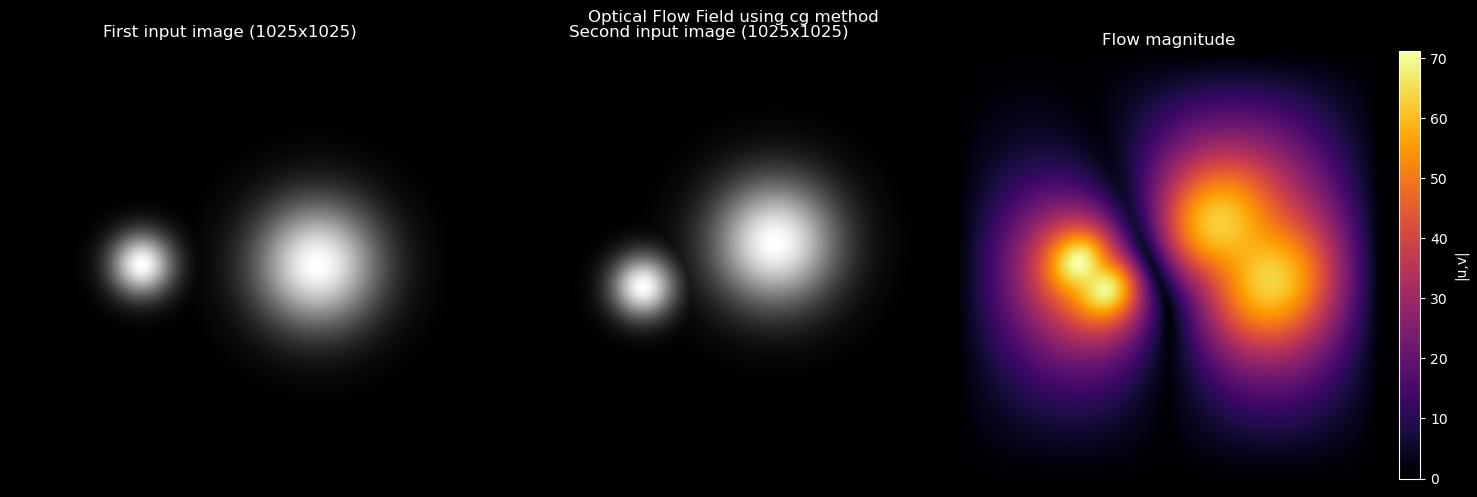

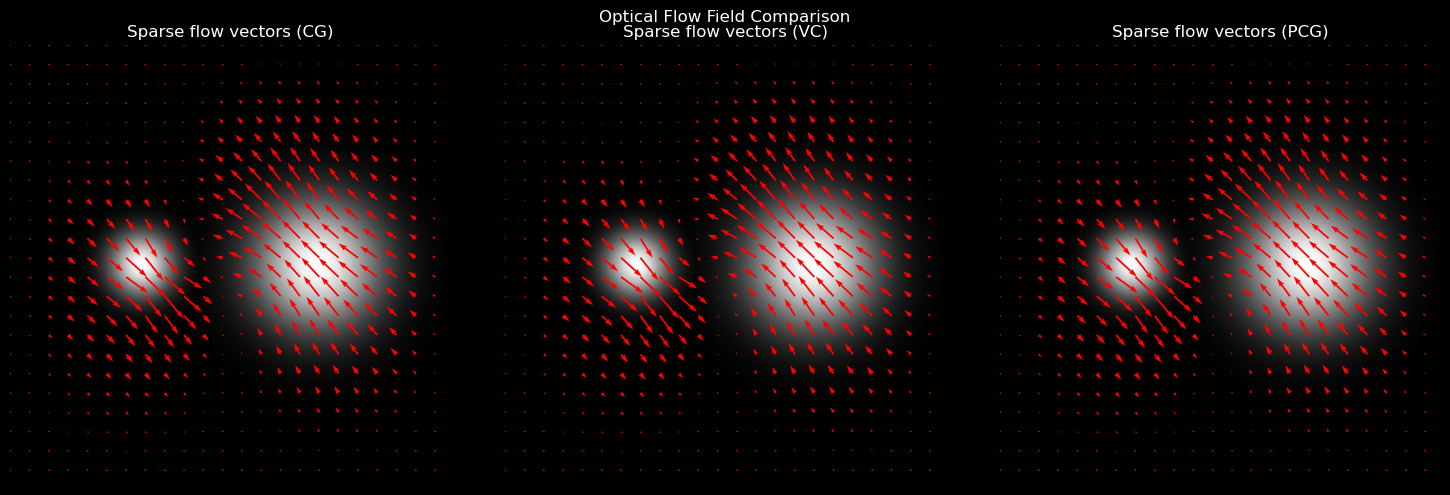

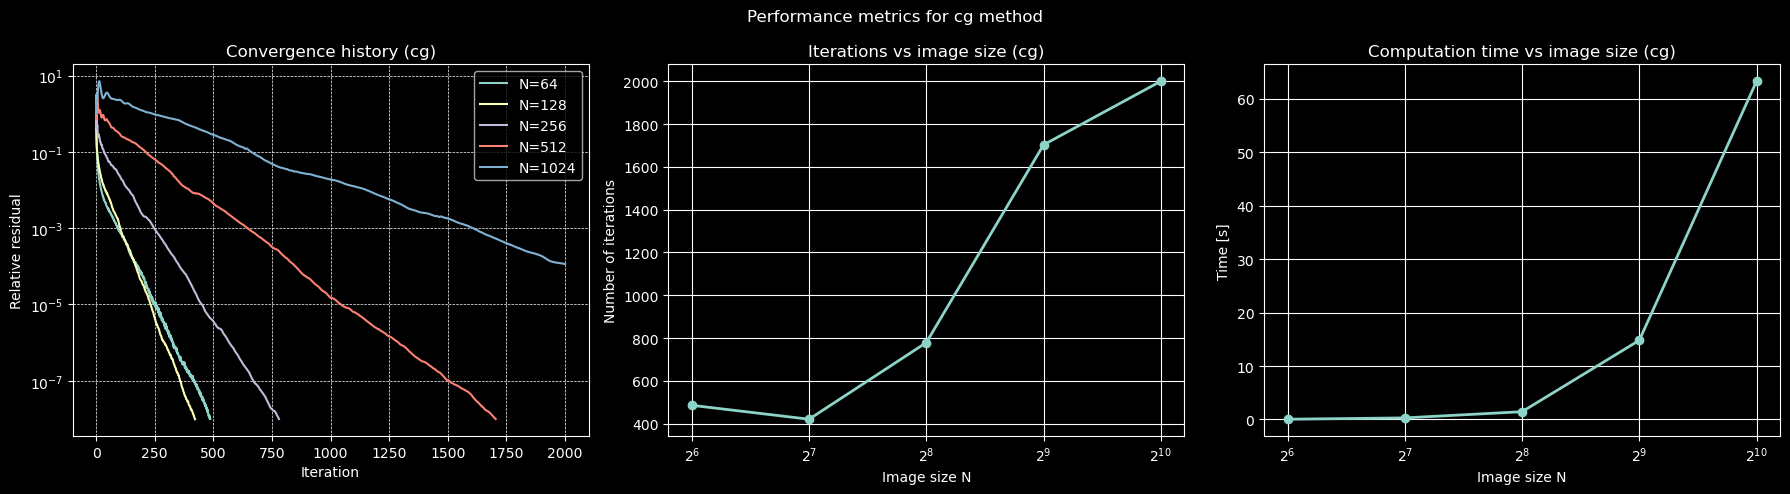

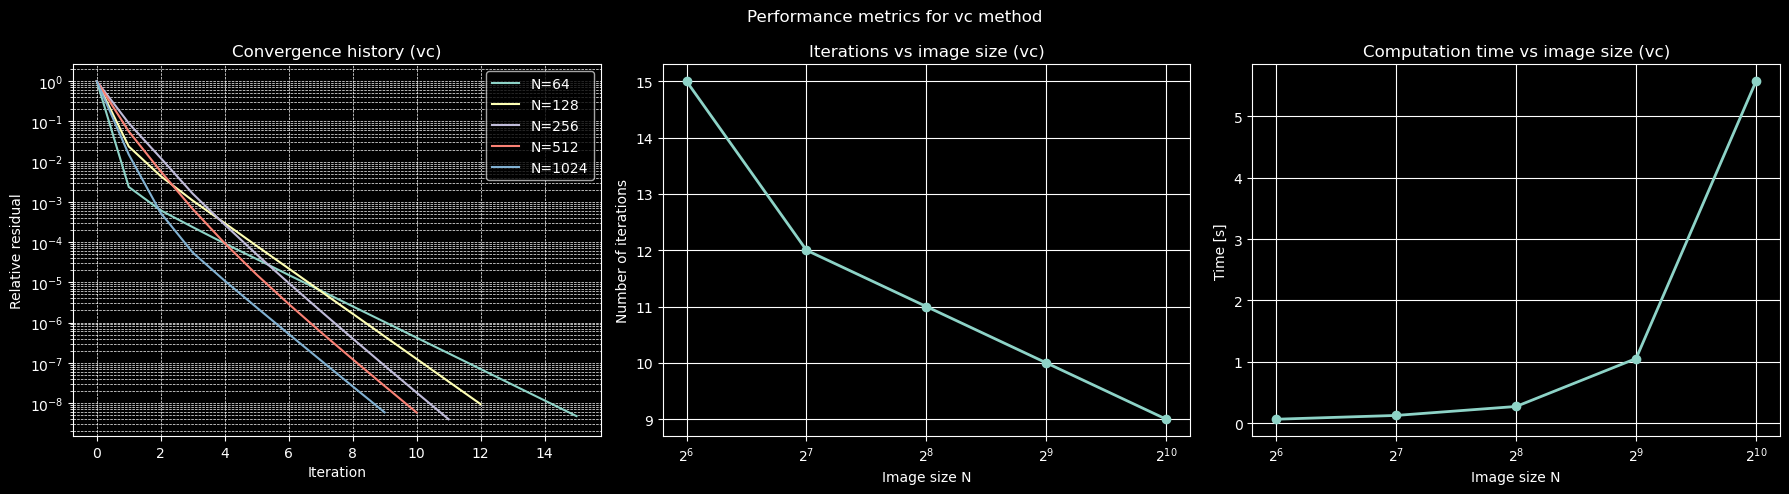

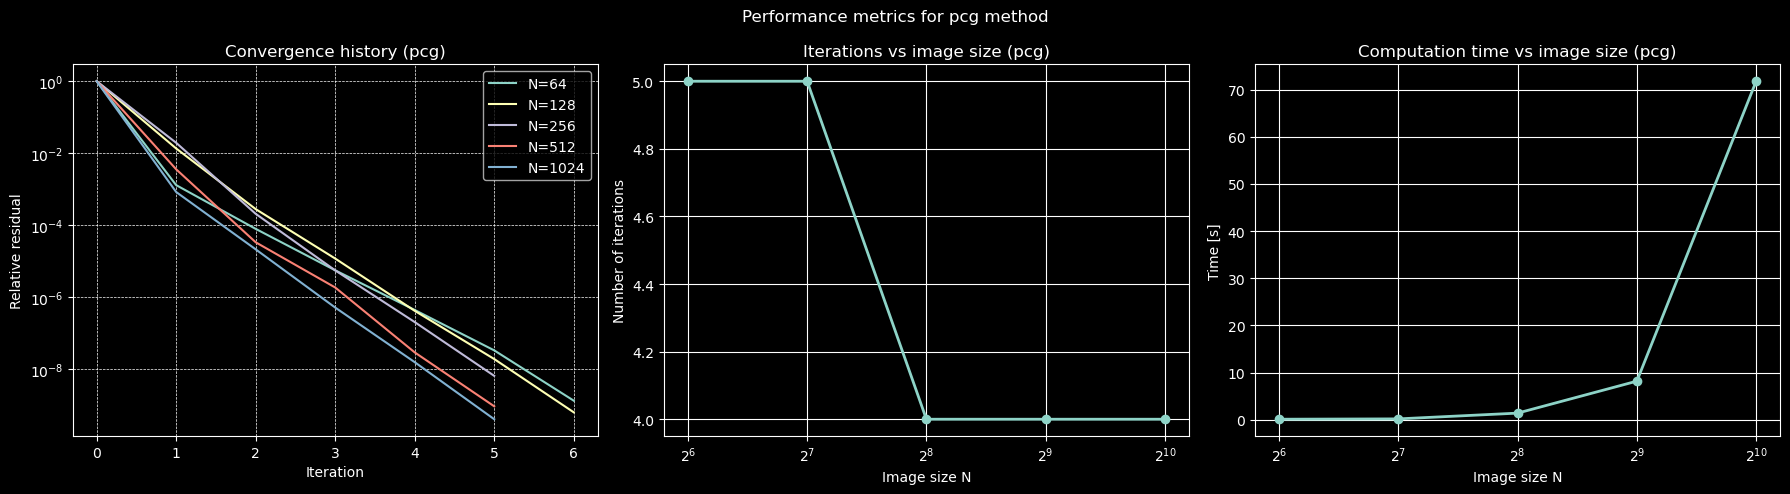

|    N | method   |   iterations |   time_s |   it_per_s |   mean_conv_factor |   final_rel_res |
|-----:|:---------|-------------:|---------:|-----------:|-------------------:|----------------:|
|   64 | cg       |          486 |   0.0403 |   1.21e+04 |            0.963   |        1e-08    |
|   64 | pcg      |            5 |   0.133  |  37.5      |            0.0167  |        1.3e-09  |
|   64 | vc       |           15 |   0.0667 | 225        |            0.279   |        4.71e-09 |
|  128 | cg       |          421 |   0.289  |   1.46e+03 |            0.957   |        9.79e-09 |
|  128 | pcg      |            5 |   0.205  |  24.4      |            0.0144  |        6.18e-10 |
|  128 | vc       |           12 |   0.128  |  93.4      |            0.214   |        9.36e-09 |
|  256 | cg       |          779 |   1.45   | 538        |            0.977   |        9.9e-09  |
|  256 | pcg      |            4 |   1.43   |   2.8      |            0.00894 |        6.38e-09 |
|  256 | vc       | 

In [3]:
plot_flow_field(I0, I1, u_cg, v_cg, method='cg')
plot_quiver(I0, u_cg, v_cg, u_vc, v_vc, u_pcg, v_pcg, 45)

plot_performance(results, method="cg")
plot_performance(results, method="vc")
plot_performance(results, method="pcg")
result_table = summarize_results(results)
print(result_table.to_markdown(index=False, floatfmt=".3g"))

The results show clear differences in both convergence behaviour and scaling for the three methods. For the Conjugate Gradient (CG) method, the convergence histories become flatter as the image size increases, and the number of iterations grows from around 480 at $N=64$ to more than 1700 at $N=512$ before reaching the maximum iteration limit at $N=1024$. The runtime increases sharply with image size. This behaviour matches what is expected for CG applied to elliptic problems, where the condition number increases with finer grids. CG therefore scales poorly with respect to both iterations and time.

The multigrid V-cycle behaves differently. For all image sizes, the method converges in roughly 9 to 15 iterations, and the convergence histories look almost the same across N. This indicates that the method maintains stable convergence factors as the grid becomes finer. The runtime grows approximately linearly with N, which is consistent with the expected linear complexity of multigrid. As a result, the V-cycle is much more efficient for larger problems where the grid structure can be exploited.

The preconditioned CG (PCG), where a V-cycle is used as a preconditioner, converges in only 4 to 5 iterations for all image sizes. The convergence histories show a rapid reduction in the residual. The runtime, however, increases with image size because each iteration requires one full V-cycle. This means that although the iteration count is small, the total time does not scale as well as the V-cycle solver by itself.

All three methods converge, but their performance differs. CG slows down significantly for larger images. The V-cycle keeps both the iteration count and convergence behaviour almost constant and shows the best overall scaling. PCG achieves the smallest iteration counts, but its total runtime increases with image size because the preconditioner is expensive. The V-cycle performs especially well in these experiments because the test images have a regular grid structure and smooth coefficient fields. This produces an elliptic system that matches the assumptions under which multigrid is most effective. In addition, the regularisation parameter scales with the image size through $\lambda^k = 4^{k−4}$, which increases $\lambda$ for finer grids. A larger $\lambda$ strengthens the diffusion term and further improves the conditioning of the problem at higher resolutions. Together,this creates conditions that are close to ideal for multigrid, resulting in stable and nearly size independent convergence of the V-cycle solver.

#### V-Cycle Solver Tests
Below we are running nummerical tests on the V-cycle solver, on the synthetically generated image. This image is as discussed earlier optimied for V-cylces. The below code is based on a function that runs the V-cycle with different combinations of input parameters. These results are saved in a dict, and we plot how iterations and runtime for V-cycles are affected by varyin the various parameters.

First we compare iterations and time with how many leveles the V-cycle uses. Then we compare how presmoothing and postsmoothing affect iteration and runtime, as well as looking at how combinations of presmoothing and postsmoothing affects iteration and computational time. 

In [ ]:
N = 256*2 #Runs in 15 min with this size, much faster wil smaller N
s1_list = [1, 2, 3, 4]
s2_list = [1, 2, 3, 4]          
level_list = [2,3, 4, 5]          
lambda_base = 256.0             # from lamnda_k formula for N=256
lambda_list = [lambda_base / 4, lambda_base, lambda_base * 4]  

vc_records = run_vc_param_grid(
    N=N,
    s1_list=s1_list,
    s2_list=s2_list,
    level_list=level_list,
    lambda_list=lambda_list,
    generate_test_image=generate_test_image,
    image_preprocess=image_preprocess,
    of_vc=of_vc,
    testcase=2,
    tol=1e-8,
    maxit=2000,
)



Below we see a comparison of how parameters change the performance for the V-cycles: 

In [ ]:
N = 256**2 
s1_list = [1, 2, 3, 4]
s2_list = [1, 2, 3, 4]       
level_list = [2,3, 4, 5]    
lambda_base = 256.0             # from λ_k formula for N=256
lambda_list = [4**2,lambda_base / 4, lambda_base, lambda_base * 4]  # [64, 256, 1024]

vc_records = run_vc_param_grid(
    N=N,
    s1_list=s1_list,
    s2_list=s2_list,
    level_list=level_list,
    lambda_list=lambda_list,
    generate_test_image=generate_test_image,
    image_preprocess=image_preprocess,
    of_vc=of_vc,
    testcase=2,
    tol=1e-8,
    maxit=2000,
)



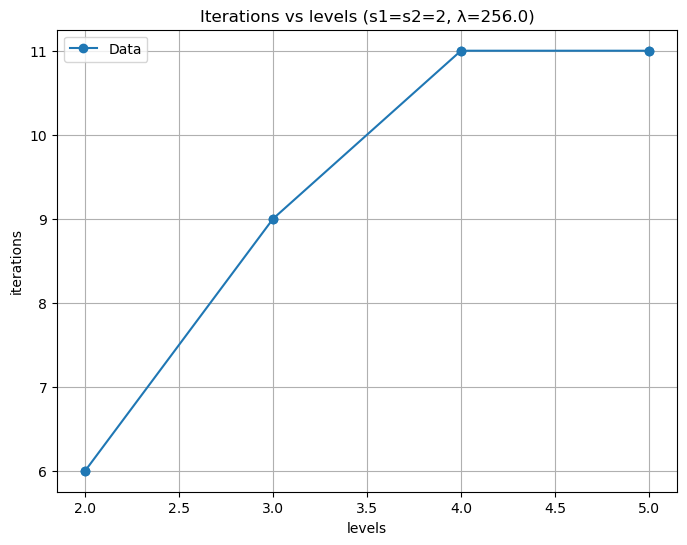

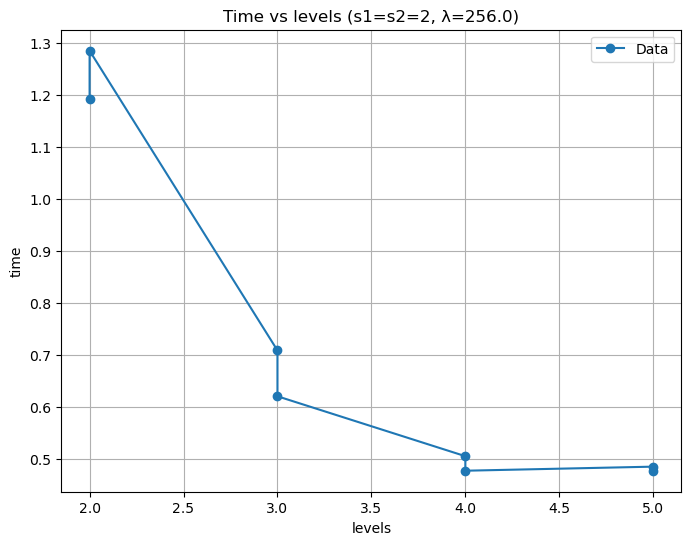

In [ ]:
plot_vc_param_comparison(
    records=vc_records,
    x_param="levels",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "lambda": lambda_base, "s1": 2, "s2": 2},
    title=f"Iterations vs levels (s1=s2=2, λ={lambda_base})"
)

plot_vc_param_comparison(
    records=vc_records,
    x_param="levels",
    y_param="time",
    group_by=None,
    filters={"N": N, "lambda": lambda_base, "s1": 2, "s2": 2},
    title=f"Time vs levels (s1=s2=2, λ={lambda_base})"
)



From the above plots we see that increasing levels increases number of iterations to convergence, but decreases runtime. The extra coarse levels are cheap to run, and sweeps decrease on coarse grids, (sweeps = max(1, s1 - level)). Thus each V-cycle is not much more expensive when levels are added. The increase in iterations can be explained by more levels means that the correction happens on a coarser grid and so extra levels can introduce modes that are more difficult to eliminate. In this case we see that 3-levels seems optimal as the time-benefit decreases after that point, and the iterations increase with more levels, so there does not seem to be much benefit to adding levels after that.

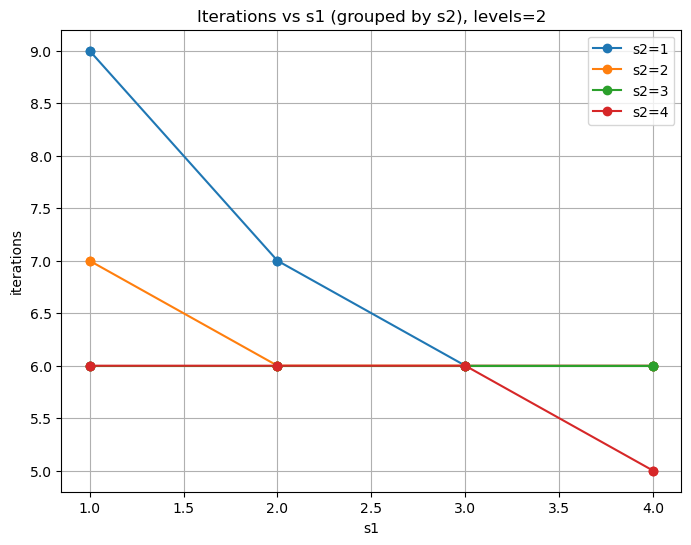

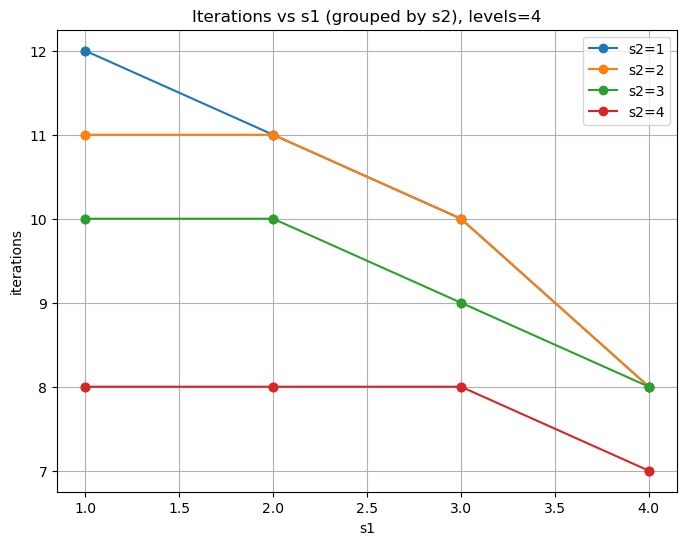

In [ ]:

#  Effect of s1

# Levels = 2
plot_vc_param_comparison(
    records=vc_records,
    x_param="s1",
    y_param="iterations",
    group_by="s2",
    filters={"N": N, "lambda": lambda_base, "levels": 2},
    title=f"Iterations vs s1 (grouped by s2), levels=2"
)

# Levels = 4
plot_vc_param_comparison(
    records=vc_records,
    x_param="s1",
    y_param="iterations",
    group_by="s2",
    filters={"N": N, "lambda": lambda_base, "levels": 4},
    title=f"Iterations vs s1 (grouped by s2), levels=4"
)

Above we see the effect of adding presmoothing. For 2 leveles, we see that adding presmoothing decreases iterations, and more so when there is little post-smoothing. Whith two leveles we see that increasing the presmoothing has little to no effect after either pre or post-smoothing is s=2. 

For 4 leveles we see stronger effect of more smoothings. This is because withouth this stronger smoothing more high-frequency errors will be sent to the coarse grid where it cannot be properly represented. When this happens the coarse-grid correction can become inaccurate and may reintroduce errors back into the fine grid. With more presmoothing these high-frequency errors will be eliminated, and only the smooth error components are passed to the coarse grids, allowing the multigrid hierarchy to operate efficiently and restoring fast convergence. Also here we can see the effect of postsmoothings, and with a stronger postsmoother, the iterations are consistently lower. If there are new high-frequency errors introduces to the fine grid from innacurate correction on the coarse grid, this will then be removed by the post smoother. 
We see that a presmoothing of around 3 seems optimal for this case with 4 leveles. 

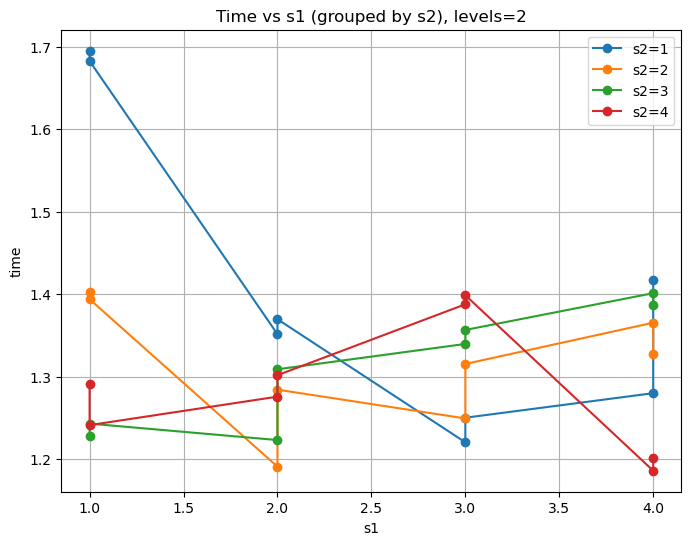

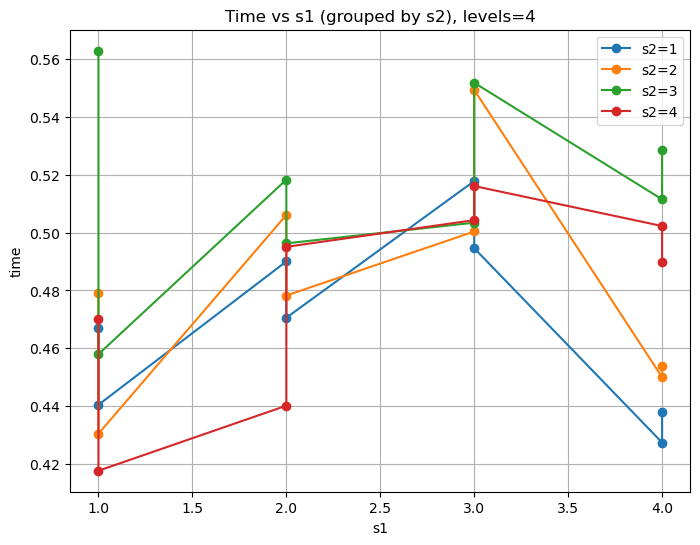

In [ ]:
# Levels = 2
plot_vc_param_comparison(
    records=vc_records,
    x_param="s1",
    y_param="time",
    group_by="s2",
    filters={"N": N, "lambda": lambda_base, "levels": 2},
    title=f"Time vs s1 (grouped by s2), levels=2"
)

# Levels = 4
plot_vc_param_comparison(
    records=vc_records,
    x_param="s1",
    y_param="time",
    group_by="s2",
    filters={"N": N, "lambda": lambda_base, "levels": 4},
    title=f"Time vs s1 (grouped by s2), levels=4"
)

Above we examine the effect of presmoothing with time to convergence. Here we can see the same trend of time negatively correlating with levels. Further we see that for two levels two pre-and post smoothings seems to be the threshold to where we gain less time to convergence for this system. The dominant work comes from working on the fine grid, so with two levels each cycle is relatively expensive. Therefore more presmoothing reduces iterations without making each cycle much more expensive. This gives a benefit until diminishing returns.

For four levels there is much more work on the coarse grids. As presmoothing is applied at every level increasing smoothing also increases smoothing operations on four grids which in turn increases the computational work so each cycle gets significantly more expensive. We can see that before s1=3 increasing presmoothing only increases computation. However, after this there is a drop as the presmoothings now make the system smooth enough before restriction to have a large enough drop in iteration count. This is most prevalent in when s2= 2, as there is a large drop in both iteration and time from s1=3 to s1=4.
This speaks for using either s1=s2=2 or increasing s1 to 4 rather than 3 to gain an effect at higher levels.

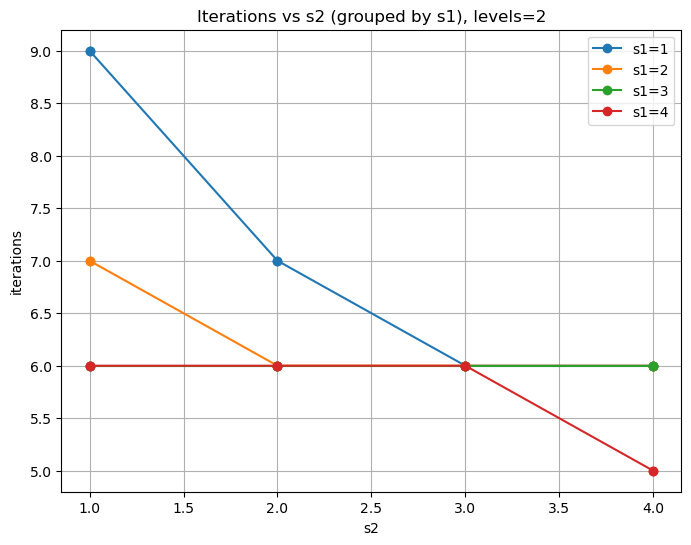

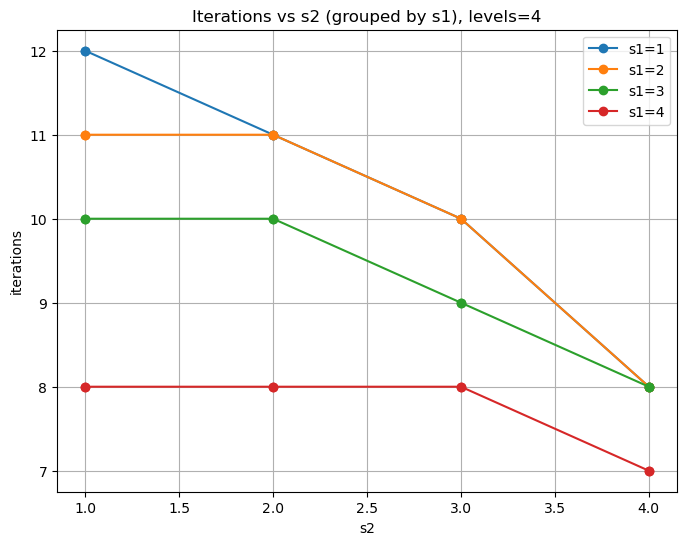

In [ ]:
# Levels = 2
plot_vc_param_comparison(
    records=vc_records,
    x_param="s2",
    y_param="iterations",
    group_by="s1",
    filters={"N": N, "lambda": lambda_base, "levels": 2},
    title=f"Iterations vs s2 (grouped by s1), levels=2"
)

# Levels = 4
plot_vc_param_comparison(
    records=vc_records,
    x_param="s2",
    y_param="iterations",
    group_by="s1",
    filters={"N": N, "lambda": lambda_base, "levels": 4},
    title=f"Iterations vs s2 (grouped by s1), levels=4"
)

In the above plots we examine how the number of post-smoothing steps affects the number of V-cycle iterations. We observe that increasing post-smoothing reduces the iteration count, particularly when the number of pre-smoothing steps is small. This is consistent with multigrid theory, the prolongation step introduces new high-frequency errors on the fine grid, and post-smoothing is responsible for removing them.

We also see that pre- and post-smoothing compensate for each other. When pre-smoothing is already strong, additional post-smoothing gives only marginal improvement. Overall, the combination s1=s2=2 seems  to be a good balance for this problem, offering near-optimal iteration counts without unnecessary smoothing cost.

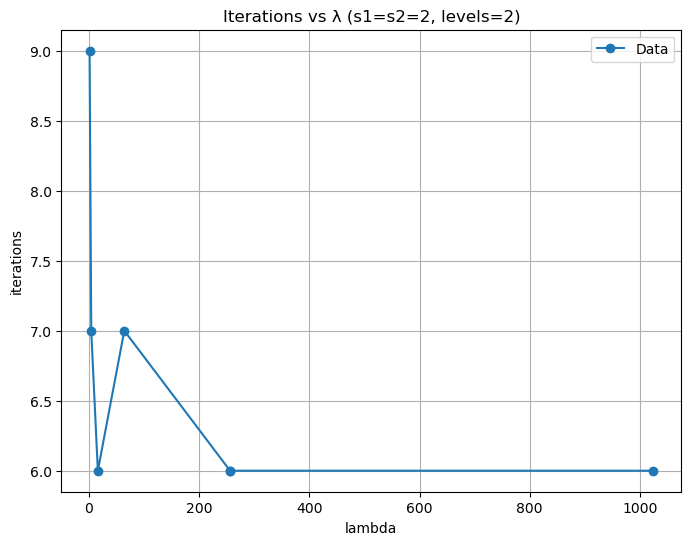

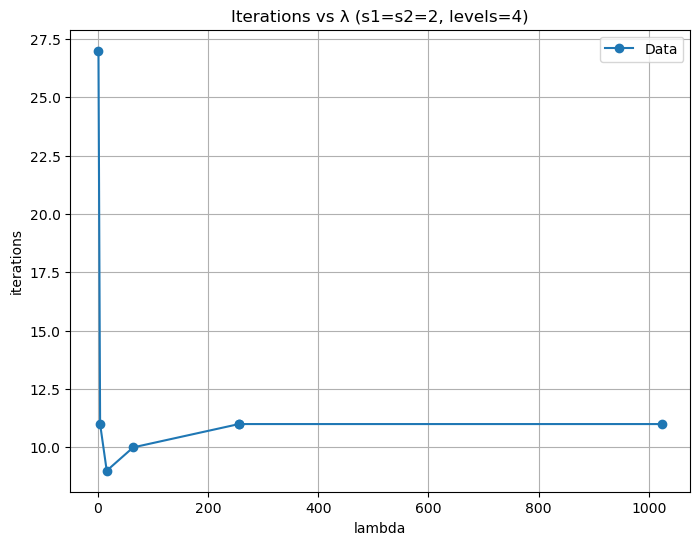

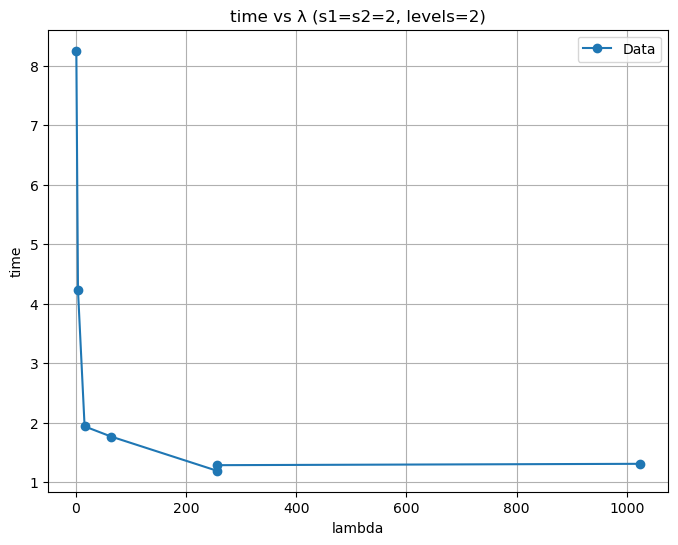

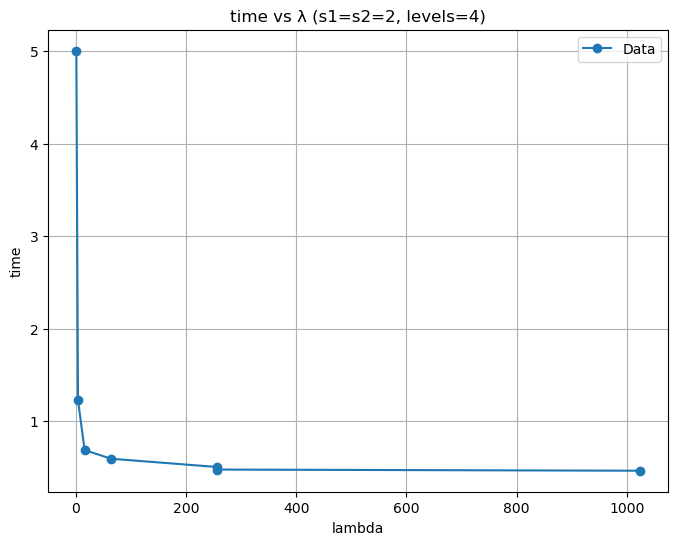

In [ ]:
# Levels = 2
plot_vc_param_comparison(
    records=vc_records,
    x_param="lambda",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "s1": 2, "s2": 2, "levels": 2},
    title=f"Iterations vs λ (s1=s2=2, levels=2)"
)

# Levels = 4
plot_vc_param_comparison(
    records=vc_records,
    x_param="lambda",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "s1": 2, "s2": 2, "levels": 4},
    title=f"Iterations vs λ (s1=s2=2, levels=4)"
)

# Levels = 2
plot_vc_param_comparison(
    records=vc_records,
    x_param="lambda",
    y_param="time",
    group_by=None,
    filters={"N": N, "s1": 2, "s2": 2, "levels": 2},
    title=f"time vs λ (s1=s2=2, levels=2)"
)

# Levels = 4
plot_vc_param_comparison(
    records=vc_records,
    x_param="lambda",
    y_param="time",
    group_by=None,
    filters={"N": N, "s1": 2, "s2": 2, "levels": 4},
    title=f"time vs λ (s1=s2=2, levels=4)"
)


### chat forklaring, usikker på om disse kan ansees å være ikke-resultater siden det er så lite info? 

With 2 levels, λ has almost no effect: both iteration count and convergence remain unchanged.
This is because the hierarchy is too shallow for coarse-grid conditioning effects to matter, and the pointwise smoother already handles λ well.

With 4 levels, λ noticeably improves convergence.
Larger λ makes the operator more elliptic and easier for multigrid, reducing both the number of iterations and the computational time.

Time fluctuations in the 2-level case are mostly measurement noise since the iteration count does not change.

##### Testing with Real Images
We now test the methods with real images instead of synthetic data. The code below performs a comparison of the three solvers over a range of lambda values. This is done by running each solver on the same real image pair with varying lambda values and recording the performance metrics. These metrics are the same as before, the number of iterations, the computation time, and the convergence history.

In [ ]:
tol = 1e-8
maxit = 2000
maxit_vc = 10 #This is done as vc plateaus after just a few iterations
sigma = 0.5
lams = [0.01, 0.1, 1, 10, 100, 1000]

frame0_path = "test_images/frame10.png"
frame1_path = "test_images/frame11.png"

results_lambda = init_lambda_results(lams)
results_lambda, u_cg, v_cg, u_vc, v_vc, u_pcg, v_pcg, I0, I1 = run_all_lambda(lams, results_lambda, frame0_path, frame1_path,tol, maxit, maxit_vc, sigma)


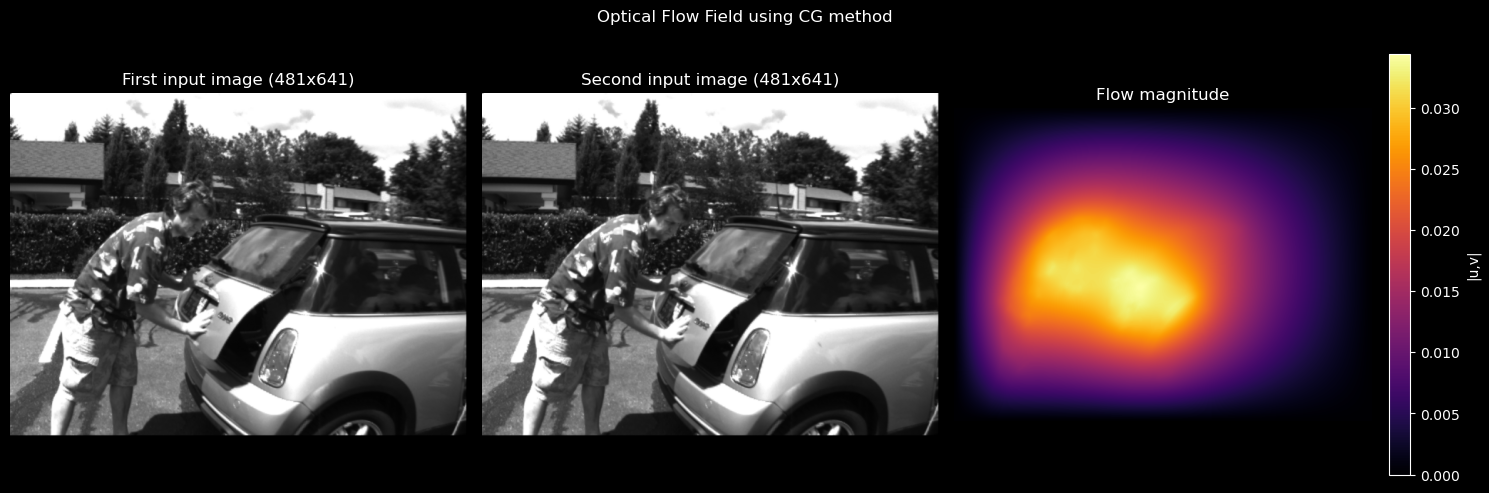

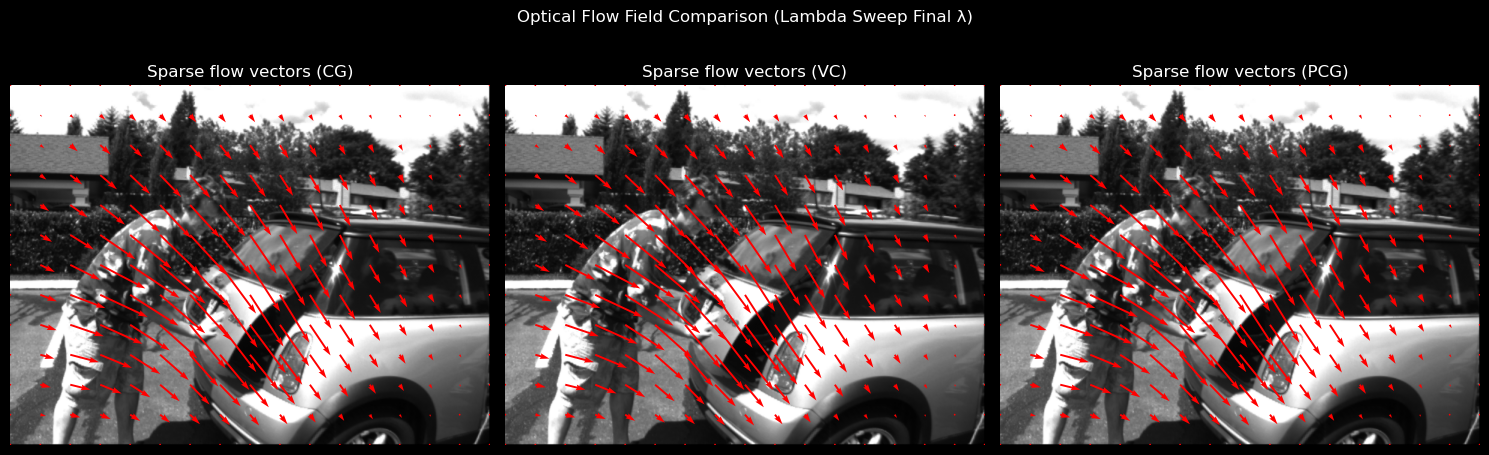

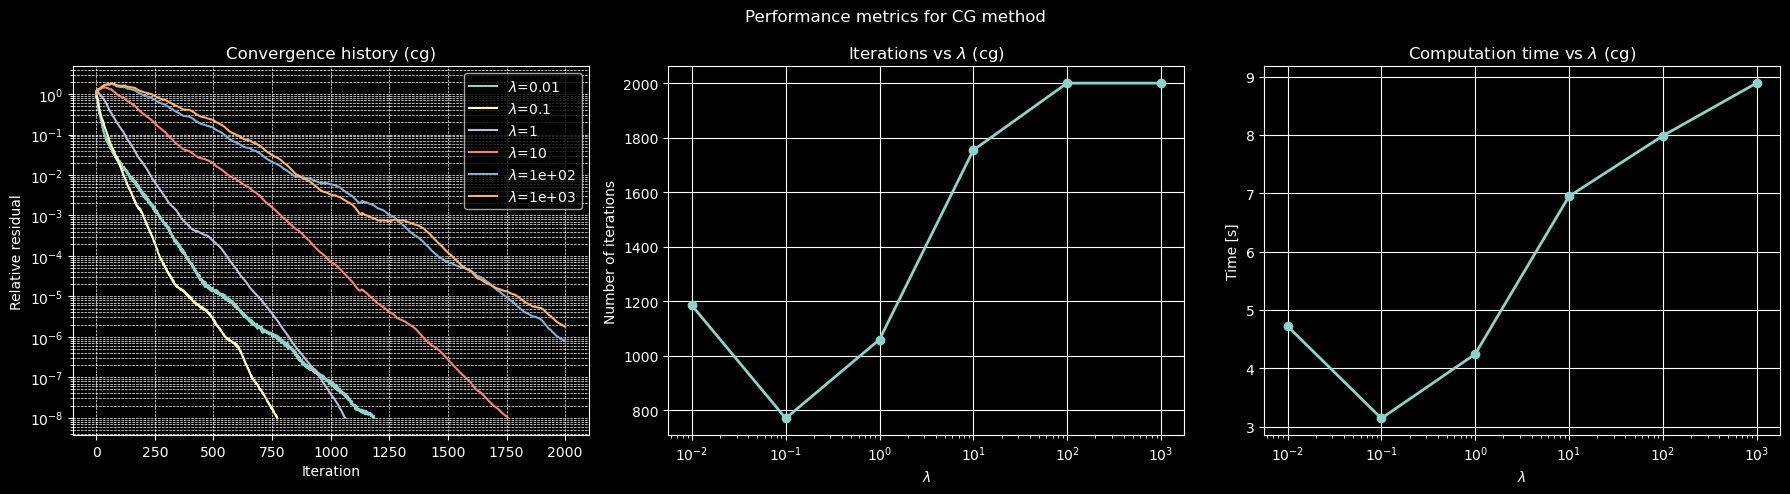

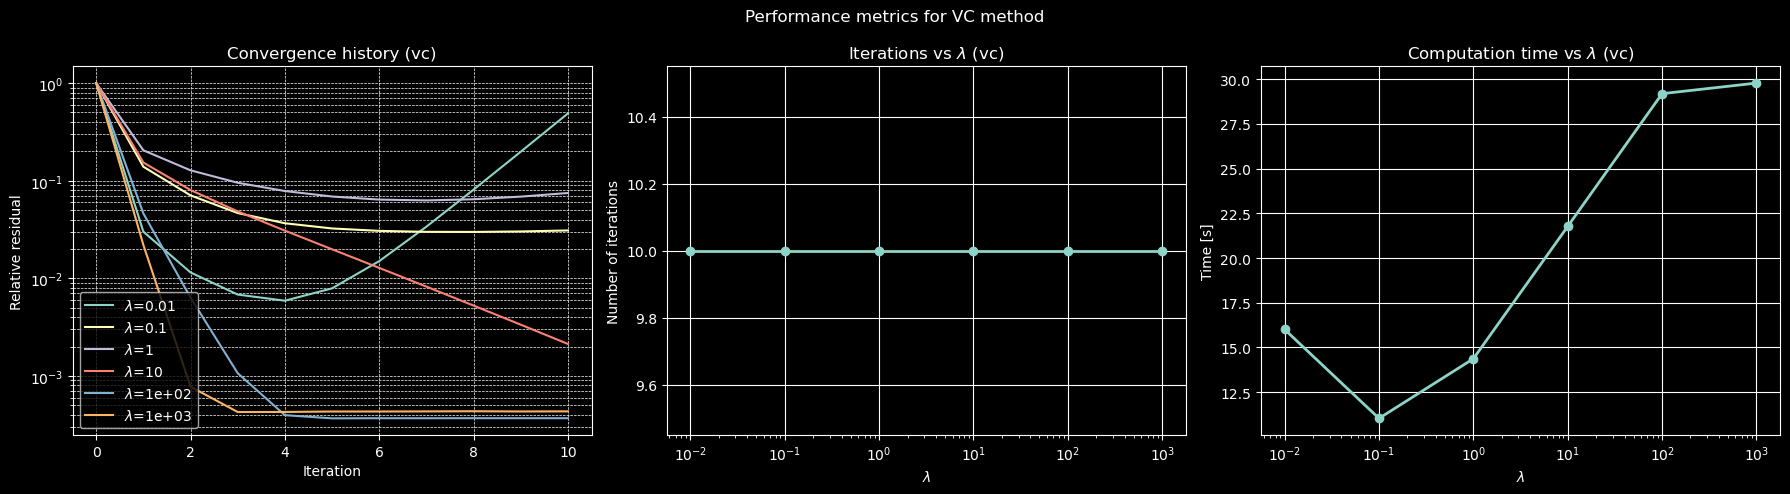

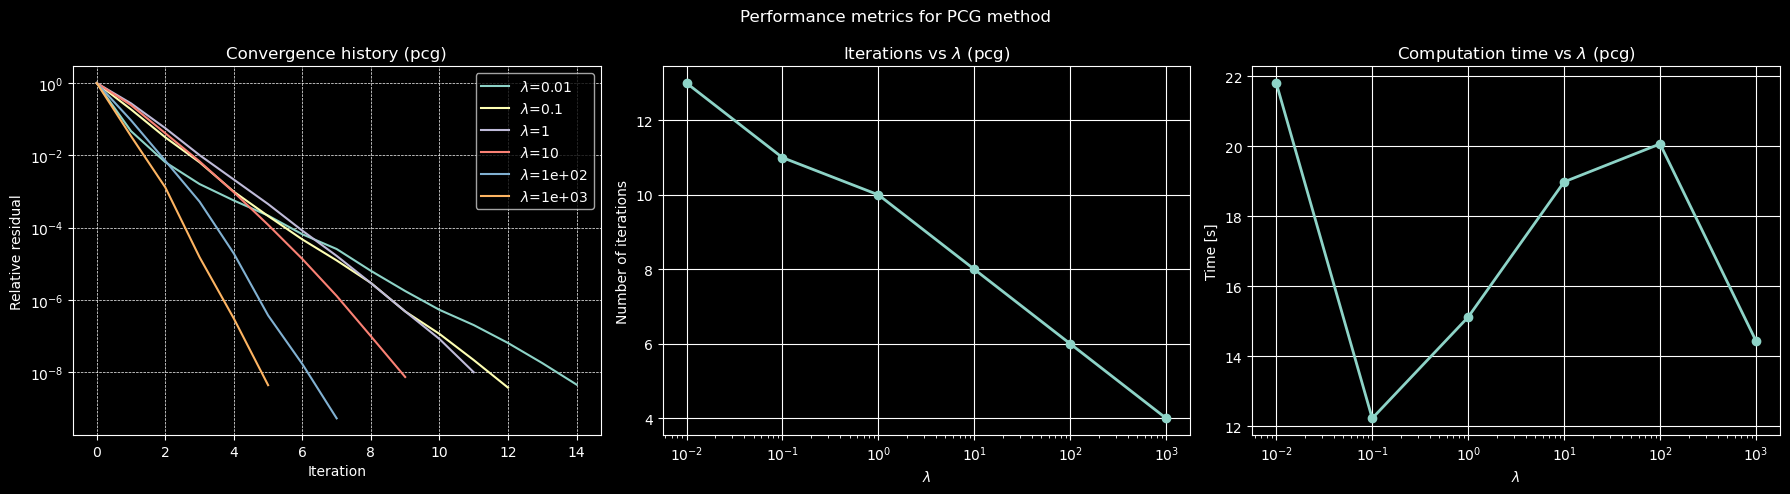

In [ ]:
plot_flow_field(I0, I1, u_cg, v_cg, method="CG")
plot_quiver_lambda(I0, u_cg, v_cg, u_vc, v_vc, u_pcg, v_pcg, step=40)

# Performance vs λ for each method
plot_performance_lambda(results_lambda, method="cg")
plot_performance_lambda(results_lambda, method="vc")
plot_performance_lambda(results_lambda, method="pcg")

From the lambda comparison graphs above, the convergence and performance behavior of the three methods varies noticeably with the regularization parameter $\lambda$. 

For CG, convergence is fastest at lower $\lambda$ values, with steep residual decay and relatively low iteration counts. As $\lambda$ increases, the regularization term begins to dominate, making the system stiffer and more difficult to solve. This leads to slower convergence, higher iteration counts, and longer runtimes. A small $\lambda$ emphasizes the data term by weakening the regularization term. The regularization term is responsible for spreading information across neighboring pixels. When $\lambda$ is small, this coupling is lost, and each pixel becomes more independent. That means the system becomes nearly diagonal or locally coupled, and each $u_{ij}, v_{ij}$ is solved mostly based on its own local image data. But from the graph we also see that this has a limit. When $\lambda > 0.01$, the regularization is weak enough that the system becomes sensitive to noise and ambiguity in flat or low-texture regions of the image. The solution becomes unstable or noisy without enough structure to enforce smoothness.

For VC the pattern is somewhat similar, though there is a large discrepancy between VC and the other methods. From the graph it is clear that VC does not converge to an acceptable solution. Insted it plateaus after just a few iterations, we will go more in depth on this later on. At low $\lambda$, the multigrid hierarchy reduces both high- and low-frequency errors, resulting in more effective convergence. As $\lambda$ increases, VC stagnates at higher residuals values. This suggests that for larger $\lambda$, the smoother is no longer effective at damping high-frequency errors, and the coarse-grid corrections become less meaningful. The increased dominance of the diffusion-like regularization term likely alters the operator in a way that breaks the assumptions underpinning multigrid efficiency. Thus, VC works better for small $\lambda$ but underlying issues with the method make it struggle regardless of what $\lambda$ value is used.

PCG combines the robustness of CG with the structure of multigrid. Across all $\lambda$ values, PCG consistently converges in much fewer iterations than CG, just 5 to 10 iterations. However, since each iteration involves a full V-cycle, the runtime is comparable to or slightly higher than CG, particularly when $\lambda$ is very small or large. The value that produced both the fastest convergence and shortest computation time was around $\lambda = 0.1$ to $\lambda = 0.01$. Still, the convergence histories show rapid residual reduction for all tested $\lambda$ values, indicating that the V-cycle serves as an effective preconditioner even if it fails as a standalone solver. This highlights the value of multigrid as a preconditioning tool.  Even when it cannot solve the problem directly, it transforms the system into one that CG can handle efficiently.

In summary, all methods show sensitivity to the choice of $\lambda$, but in different ways. CG slows down at higher $\lambda$ due to the stiffness of the system and at low $\lambda$ due to poor conditioning. V-cycle stagnates at all $\lambda$ values, but the best results were found at low $\lambda$ values. This is probably due to the failure of the smoother and coarse-grid hierarchy to handle realistic coefficient fields. PCG offers the best convergence robustness across $\lambda$ values, combining the stability of multigrid-based preconditioning with the general-purpose convergence of CG. These results emphasize the importance of matching solver structure to problem regularity, especially in real-world image data where assumptions like smooth coefficients do not hold.

##### VC Plateau Discussion
We recall the discretisation of the system, and how it can be represented in matrix form: 

For each pixel $(i,j)$ the linearised equations to be solved are

$$
I_x^2\, u_{ij} + I_x I_y\, v_{ij}
   \;-\; \lambda (A_h u)_{ij}
 = -I_t I_x,
$$

$$
I_y^2\, v_{ij} + I_x I_y\, u_{ij}
   \;-\; \lambda (A_h v)_{ij}
 = -I_t I_y.
$$


At each pixel we can write the equations in a $2\times 2$ block form:

$$
A_{ij}
\begin{bmatrix}
u_{ij} \\
v_{ij}
\end{bmatrix}
=
\begin{bmatrix}
f^u_{ij} \\
f^v_{ij}
\end{bmatrix},
$$

where

$$
A_{ij} =
\begin{pmatrix}
I_x^2 + 4\gamma & I_x I_y \\
I_x I_y & I_y^2 + 4\gamma
\end{pmatrix},
\qquad
\gamma = \frac{\lambda}{h^2},
$$

and the right–hand side is

$$
\begin{bmatrix}
f^u_{ij} \\
f^v_{ij}
\end{bmatrix}
=
\begin{bmatrix}
- I_t I_x + \lambda (u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1}) \\
- I_t I_y + \lambda (v_{i-1,j} + v_{i+1,j} + v_{i,j-1} + v_{i,j+1})
\end{bmatrix}.
$$


Collecting all $u$–values in a vector $U$ and all $v$–values in a vector $V$,
the global system can be written as

$$
\begin{bmatrix}
D_{xx} - \lambda A_h & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h
\end{bmatrix}
\begin{bmatrix}
U \\[2mm] V
\end{bmatrix}
=
\begin{bmatrix}
D_{xt} \\[2mm] D_{yt}
\end{bmatrix},
$$

with diagonal matrices

$$
D_{xx} = \operatorname{diag}(I_x^2), \qquad
D_{yy} = \operatorname{diag}(I_y^2), \qquad
D_{xy} = \operatorname{diag}(I_x I_y),
$$

and the right–hand side

$$
D_{xt} = -\operatorname{diag}(I_x I_t), \qquad
D_{yt} = -\operatorname{diag}(I_y I_t).
$$


The regularisation term uses the standard 5–point Laplacian

$$
A_h =
\frac{1}{h^2}
\begin{bmatrix}
 & -1 & \\
-1 & 4 & -1 \\
 & -1 &
\end{bmatrix}.
$$


From the matrix $A_{ij}$ we see how the spatial derivatives control both the conditioning of the system and the strength of the coupling of the unknowns. 

Our implementation of the V-cycle uses red-black Gauss-Seidel smoothing, that solved this 2x2 block exactly at each grid point using the latest available update for the neighboring values. Thus, whenever the local block is well conditioned, and coefficients vary smoothly, the V-cycle smoother is effective at dampening the high-frequency error.

We see in our tests that the V-cycle solver performs highly on the synthetic data, but stagnates before convergence for the real image. In the below image, we see the visualisation of the spatial and temporal derivatives of the synthetic and real image.

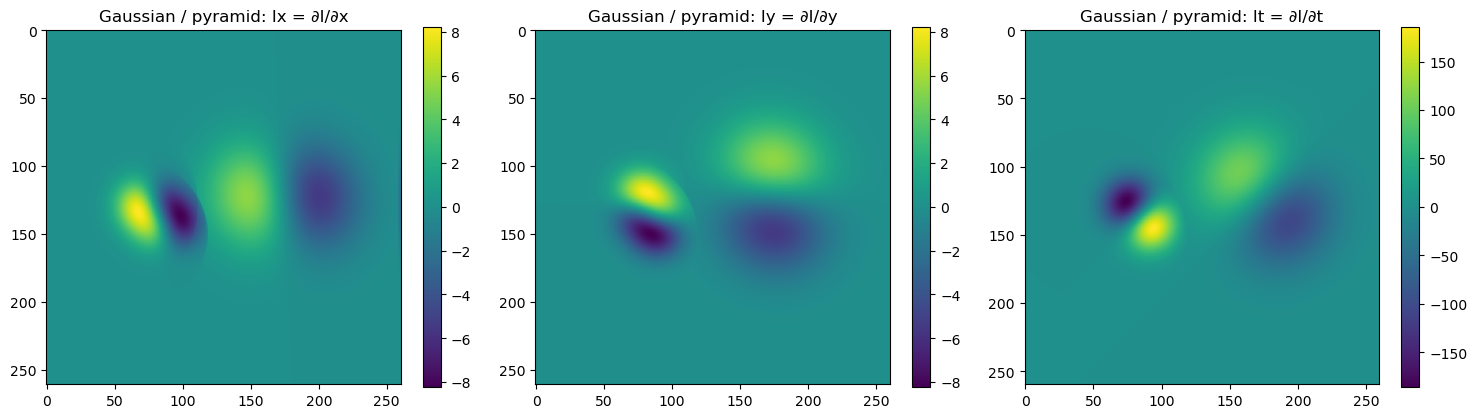

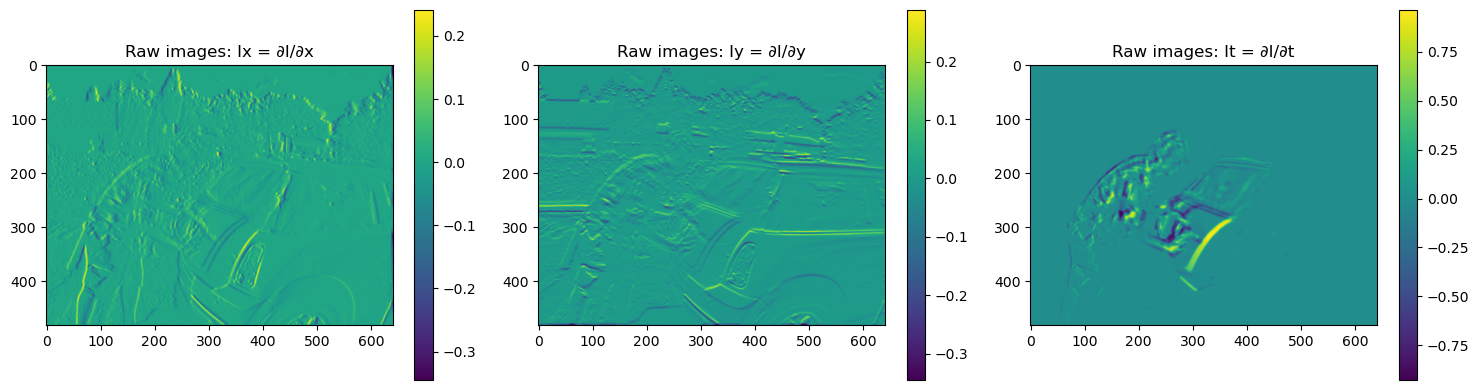

In [ ]:
u0r, v0r, Ixr, Iyr, rhsur, rhsvr, Im_0r, Im_1r = image_preprocess(Im_0, Im_1_raw, 1)
u0, v0, Ix, Iy, rhsu, rhsv, Im_0, Im_1 = image_preprocess(Im_0_raw, Im_1_raw, 1)


Im_0, Im_1 = generate_test_image(260, testcase=2)
u0, v0, Ix, Iy, rhsu, rhsv, I0, I1 = image_preprocess(Im_0, Im_1)
plot_gaussian_gradients(Im_0, Im_1, Ix, Iy, title_prefix="Gaussian / pyramid")
plot_gaussian_gradients(Im_0r, Im_1r, Ixr, Iyr, title_prefix="Raw images")

For the synthetic image both spatial and temporal derivatives are smooth and well-behaved. There are no sharp edges and irregularities. 

In the other hand, we see a lot of irregularities and rapid changes in the real image.

This leads to the local $A_{ij}$ blocks being regular in the synthetic case, and less regular. This creates different kinds of issues for the V-cycle solver.

One issue is the regions where one spatial derivative dominates, and the determinant of the system that is solved in Gauss-Seidel is close to 0 so the solution is clamped to avoid dividing by zero and thus not yielding a good smoothing for that region. As we can see there are quite a lot of these regions.

A different issue is that there are many instances of regions where 


$ I_x \approx 0, \qquad I_y \approx 0$. 


In this case the equation locally reduces to 


$-\lambda A_h u \approx 0, \qquad -\lambda A_h v \approx 0$.


 However, it might be within a region where there is a lot of change to the derivatives(in opposition to similar situations in the synthetic image where the derivatives are only zero within regions of zero-derivatives). Thus in these areas the operator is almost pure Laplacian. This creates variation between pixels, and so a lot of variation in the local matrixes.


$    A_{ij} =
    \begin{pmatrix}
        I_x^2 + 4\gamma & I_x I_y \\
        I_x I_y & I_y^2 + 4\gamma
    \end{pmatrix}.$


These jumps can decrease multigrid performance, as the smoother is only able to remove high-frequency errors relative to the local operator. Large local variation then decreases the smoother performance. Thus the coarser grid will have difficulties representing the error modes across regions with strongly varying coefficients.

In real images there can also be issues related to the brightness changing in intensity, and so the brightness is non-consistent. This can make it so the right hand side with the temporal derivatives are not compatible with the linear system.

#### Conclusion
The performance of CG, VC, and PCG solvers varies significantly with image size and the regularization parameters $\lambda$, max level, s1 and s2. The former three only applying to VC and PCG. Also important for the behavior of the methods is if the image is synthetic or real.

For increasing image sizes, CG slows down markedly, iteration counts grow rapidly, and it fails to converge at higher resolutions. This matches expectations, as finer grids worsen the system’s conditioning. VC maintains nearly constant iteration counts and runtime grows linearly with size, demonstrating the optimal scaling expected from multigrid—though this only holds for synthetic images with smooth coefficients. PCG combines CG's robustness with VC's structure, converging in just 4–5 iterations regardless of size, but each iteration is expensive due to the embedded V-cycle. From this it is clear that for synthetic images, the multigrid structure of VC and PCG provides a significant advantage.

For real images, the situation is more complex. As $\lambda$ varies, CG performs best at low to moderate values ($\lambda \approx 0.01$–$0.1$), where regularization balances smoothness and data quality. At very low $\lambda$, the system becomes under-regularized and unstable, and at high $\lambda$, it becomes stiff and slow to solve. VC performs best at small $\lambda$ but stagnates quickly for all values when applied to real images, due to ineffective smoothing and coarse-grid correction. PCG remains robust across the full range, benefiting from VC's structure while overcoming its convergence issues.

Testing on the max level, s1 and s2 parameters showed that increasing max levels generally reduced runtime but increased iterations, with diminishing returns beyond 3 levels. More pre-smoothing, s1, consistently improved convergence, especially with fewer levels, while post-smoothing, s2, helped correct errors introduced during prolongation. A balance of s1 = s2 $\approx$ 2-3 often provided good performance to computation for VC. However, for v-cycle as a preconditioner s1 and s2 should be lower, in order to maintain efficiency. 

Overall, CG is effective for small, well-conditioned problems. VC is efficient on synthetic, structured data but unreliable on real images. PCG offers the best balance of speed and robustness across varying $\lambda$ and grid sizes. Thus the optimal choice of solver is situational. For a synthetic image, VC is preferred, while for real images PCG is preferred if the image is large or complex, if small, CG may be effective due to the lower computational cost.

#### AI - Declaration
AI has been utilized to help with debugging of code and implementation of some plotting functions. AI has been used in brainstorming what to plot and how to visualize the results effectively. The code where AI has been used is indicated with comments.